In [1]:
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt

warnings.simplefilter('ignore')
path = Path('data')

# Quick tour to *python-ctd*, *gsw*, *pocean-core*, and *erddapy*

## python-ctd

[https://github.com/pyoceans/python-ctd](https://github.com/pyoceans/python-ctd)

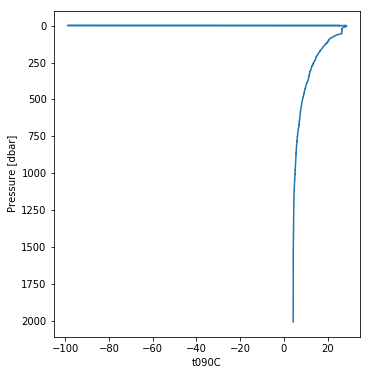

In [2]:
from ctd import DataFrame

fname = path.joinpath('g01l06s01.cnv.gz')
cast = DataFrame.from_cnv(fname)
downcast, upcast = cast.split()

fig, ax = downcast['t090C'].plot()

In [3]:
from ctd import DataFrame, Series, lp_filter, movingaverage

cast = DataFrame.from_cnv(fname, below_water=True)
cast = downcast[['t090C', 'c0S/m', 'dz/dtM', 'pumps', 'flag']]

# 00-Apply flags and smooth velocity with a 2 seconds windows.
cast = cast[cast['pumps']]
cast = cast[~cast['flag']]  # True for bad values.
cast['dz/dtM'] = movingaverage(cast['dz/dtM'], window_size=48)
    
# 01-Filter pressure.
cast.index = lp_filter(
    cast.index,
    sample_rate=24.0, time_constant=0.15
)

# 02-Remove pressure reversals.
cast = cast.press_check()
cast = cast.dropna()

# 03-Loop Edit.
cast = cast[cast['dz/dtM'] >= 0.25]  # Threshold velocity.

In [4]:
# 04-Remove spikes.
kw = {'n1': 2, 'n2': 20, 'block': 100}
cast = cast.apply(Series.despike, **kw)

# 05-Bin-average.
cast = cast.apply(Series.bindata, **{'delta': 1.0})

# 06-interpolate.
cast = cast.apply(Series.interpolate)

# 07-Smooth.
kw = {'window_len': 21, 'window': 'hanning'}
cast = cast.apply(Series.smooth, **kw)

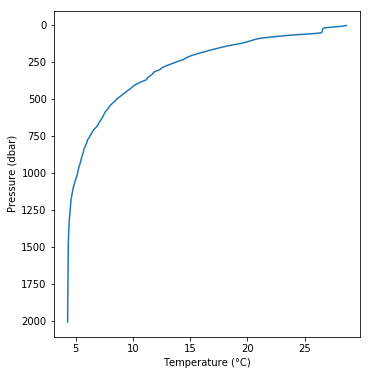

In [5]:
fig, ax = cast['t090C'].plot()
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel(u'Temperature (°C)');

## GSW

[https://github.com/TEOS-10/GSW-Python](https://github.com/TEOS-10/GSW-Python)

In [6]:
import gsw

lat = downcast['latitude'].iloc[0]
lon = downcast['latitude'].iloc[0]

cast['z'] = -gsw.z_from_p(cast.index, lat)

cast['SP'] = gsw.SP_from_C(
    cast['c0S/m']*10,
    cast['t090C'],
    cast.index
)

cast['SA'] = gsw.SA_from_SP(
    cast['SP'],
    cast.index,
    lon, lat
)

cast['CT'] = gsw.CT_from_t(
    cast['SA'],
    cast['t090C'],
    cast.index
)

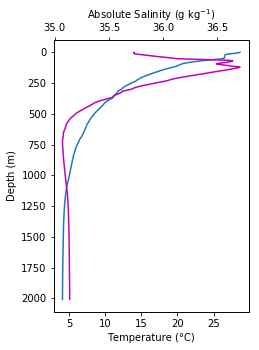

In [7]:
fig, ax0 = plt.subplots(figsize=(3.5, 5))
ax0.plot(cast['CT'], cast.index)
ax0.invert_yaxis()
ax1 = ax0.twiny()
ax1.plot(cast['SA'], cast.index, color='m')
ax0.set_ylabel('Depth (m)')
ax0.set_xlabel(u'Temperature (°C)')
ax1.set_xlabel(r'Absolute Salinity (g kg$^{-1}$)');

## pocean-core

[https://github.com/pyoceans/pocean-core](https://github.com/pyoceans/pocean-core)

In [8]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

x = np.arange(100, 110, 0.1)
start = datetime.now() - timedelta(days=7)

df = pd.DataFrame({
    'time': [start + timedelta(days=n) for n in range(len(x))],
    'longitude': -48.6256,
    'latitude': -27.5717,
    'depth': 10,
    'u': np.sin(x),
    'v': np.cos(x),
    'station': 'fake buoy',
})

In [9]:
df.tail()

,time,longitude,latitude,depth,u,v,station
95,2018-11-16 18:00:58.834009,-48.6256,-27.5717,10,0.440129,-0.897934,fake buoy
96,2018-11-17 18:00:58.834009,-48.6256,-27.5717,10,0.348287,-0.937388,fake buoy
97,2018-11-18 18:00:58.834009,-48.6256,-27.5717,10,0.252964,-0.967476,fake buoy
98,2018-11-19 18:00:58.834009,-48.6256,-27.5717,10,0.155114,-0.987897,fake buoy
99,2018-11-20 18:00:58.834009,-48.6256,-27.5717,10,0.055714,-0.998447,fake buoy


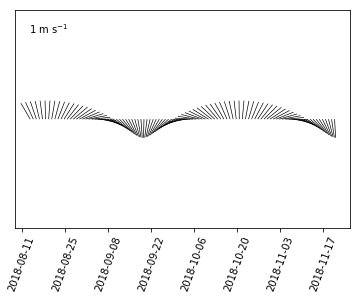

In [10]:
from oceans.plotting import stick_plot

q = stick_plot([t.to_pydatetime() for t in df['time']],
               df['u'], df['v'])
qk = plt.quiverkey(q, 0.1, 0.85, 1,
                  "%s m s$^{-1}$" % 1,
                  labelpos='N', coordinates='axes')

_ = plt.xticks(rotation=70)

In [11]:
attributes = {
    'global': {
        'title': 'Fake mooring',
        'summary': 'Vector current meter ADCP @ 10 m',
        'institution': 'Restaurant at the end of the universe',
        'cdm_timeseries_variables': 'station',
        'subsetVariables': 'depth',
    },
    'longitude': {
        'units': 'degrees_east',
        'standard_name': 'longitude',
    },
    'latitude': {
        'units': 'degrees_north',
        'standard_name': 'latitude',
    },
    'z': {
        'units': 'm',
        'standard_name': 'depth',
        'positive': 'down',
    },
}

In [12]:
attributes.update({
    'u': {
        'units': 'm/s',
        'standard_name': 'eastward_sea_water_velocity',
    },
    'v': {
        'units': 'm/s',
        'standard_name': 'northward_sea_water_velocity',
    },
    'station': {
        'cf_role': 'timeseries_id'
    },
})

axes = {'t': 'time', 'x': 'longitude', 'y': 'latitude', 'z': 'depth'}

In [13]:
from pocean.dsg.timeseries.om import OrthogonalMultidimensionalTimeseries
from pocean.utils import downcast_dataframe


df = downcast_dataframe(df)

dsg = OrthogonalMultidimensionalTimeseries.from_dataframe(
    df,
    output='fake_buoy.nc',
    attributes=attributes,
    axes=axes,
)

In [14]:
!ncdump -h fake_buoy.nc

netcdf fake_buoy {
dimensions:
	time = 100 ;
	station = 1 ;
variables:
	int crs ;
	string station(station) ;
		station:cf_role = "timeseries_id" ;
		station:long_name = "station identifier" ;
	double time(time) ;
		time:units = "seconds since 1990-01-01 00:00:00Z" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
	double latitude(station) ;
		latitude:axis = "Y" ;
		latitude:units = "degrees_north" ;
		latitude:standard_name = "latitude" ;
	double longitude(station) ;
		longitude:axis = "X" ;
		longitude:units = "degrees_east" ;
		longitude:standard_name = "longitude" ;
	int depth(station) ;
		depth:_FillValue = -9999 ;
		depth:axis = "Z" ;
	double u(station, time) ;
		u:_FillValue = -9999.9 ;
		u:units = "m/s" ;
		u:standard_name = "eastward_sea_water_velocity" ;
		u:coordinates = "time depth longitude latitude" ;
	double v(station, time) ;
		v:_FillValue = -9999.9 ;
		v:units = "m/s" ;
		v:standard_name = "northward_sea_water_velocity" ;
		v:coordinates = "time depth longitude la

## erddapy: https://github.com/pyoceans/erddapy

In [15]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
    response='csv',
)

In [16]:
e.dataset_id = 'whoi_406-20160902T1700'

e.constraints = {
    'time>=': '2016-07-10T00:00:00Z',
    'time<=': '2017-02-10T00:00:00Z',
    'latitude>=': 38.0, 'latitude<=': 41.0,
    'longitude>=': -72.0, 'longitude<=': -69.0,
}

e.variables = ['depth', 'latitude', 'longitude',
               'salinity', 'temperature', 'time']

print(e.get_download_url())

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.csv?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


In [17]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-03 20:15:46,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46,8.43,40.990881,-71.12439,32.224503,20.5691


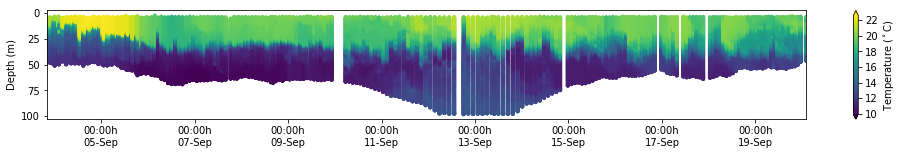

In [18]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth'], s=15,
                c=df['temperature'], marker='o', edgecolor='none')

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

# Other packages of interest

- *compliance-checker* and its plugins: *cc-plugin-ugrid*, *cc-plugin-glider*, *cc-plugin-ncei*, and *cc-plugin-sgrid*)

- *pyoos*: A Python library for collecting Met/Ocean observations
- *odvc*: Ocean Dimensionless Vertical Coordinates
- *qartod*: Automated quality assurance and quality control for oceanographic datasets 
- *ciso*: Fast iso-surfaces calculator
- *ncml*: Python tools for manipulating NCML (NetCDF Markup) files

In [19]:
from IPython.display import IFrame

src = 'https://ioos.github.io/notebooks_demos/code_gallery'
IFrame(src=src, width=950, height=500)